In [11]:
# import statements
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from collections import deque
from tqdm.notebook import tqdm
import random
import matplotlib.pyplot as plt
import importlib

import player
import rl_player
importlib.reload(player)
importlib.reload(rl_player)
from player import *
from rl_player import *

In [12]:
NUM_GAMES = 1000

def run_simulation(players, shuffle_turn_order=False, num_games=NUM_GAMES):
    winners = []
    for _ in range(num_games):
        if shuffle_turn_order:
            random.shuffle(players)
        game = Game(players)
        while len(game.game_state['players']) > 1:
            game.simulate_turn()
        winner = game.game_state['players'][0].name
        winners.append(winner)
    return winners

In [13]:
def train_agent(agent, env, num_episodes, batch_size, epsilon_decay, sample_freq=10, display_progress=False, save_model=False, player_types=[]):
    total_rewards = []
    epsilon = 1.0
    win_rates = []

    for episode in tqdm(range(num_episodes), desc='Episode Loop'):
        initial_state = env.reset()
        state = initial_state
        done = False
        total_reward = 0

        while not done:
            # Choose an action using epsilon-greedy strategy
            action = agent.get_action(state, agent.name, epsilon)

            # Take the chosen action and observe the next state, reward, and done flag from the environment
            next_state, reward, done = env.step(action)

            # Add the experience to the agent's replay buffer
            agent.add_experience(state, action, reward, next_state, done)

            # Update the agent's Q-network if there are enough experiences in the replay buffer
            if len(agent.replay_buffer) >= batch_size:
                agent.replay_experience(batch_size, agent.name)

            # Update the game state and history for the next iteration
            state = next_state

            # Accumulate the total reward
            total_reward += reward

        # Decay epsilon
        epsilon *= epsilon_decay

        # Save the total reward for this episode
        total_rewards.append(total_reward)

        # Print the episode number and total reward
        # print(f"Episode {episode + 1}/{num_episodes} - Total Reward: {total_reward}")

        if display_progress and episode % sample_freq == 0:
            rl_decision = get_rl_decision(agent.model, agent.name)
            RL_FUNCS = {'decision_fn': rl_decision, 'block_fn': income_block, 'dispose_fn': random_dispose, 'keep_fn': random_keep}
            players = [Player(agent.name, RL_FUNCS)] + env.players[1:]
            winners = run_simulation(players)
            win_pct = len([w for w in winners if w == agent.name]) / len(winners)
            win_rates.append(win_pct)

    if display_progress:
        plt.plot([x * sample_freq + 1 for x in list(range(len(win_rates)))], win_rates, label="agent win rate")
        plt.plot([x * sample_freq + 1 for x in list(range(len(win_rates)))], [1 / len(env.players) for _ in range(len(win_rates))], label="expected win rate", linestyle='dashed')
        plt.legend()
        plt.title('Q-Learning win rate over time')
        plt.ylabel('win rate')
        plt.xlabel('number of episodes')

    if save_model:
        agent.save_model('models/{0}-{1}-{2}'.format(len(env.players), num_episodes, ','.join(player_types)))

    return total_rewards, win_rates

Episode Loop:   0%|          | 0/5000 [00:00<?, ?it/s]

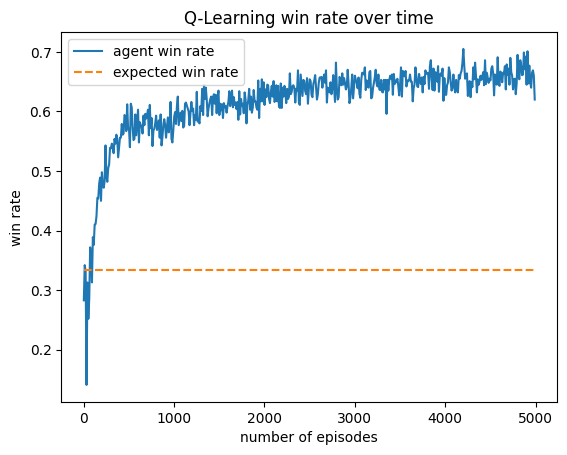

In [14]:
RLTRAINING_FUNCS = {'decision_fn': rltraining_decision, 'block_fn': income_block, 'dispose_fn': random_dispose, 'keep_fn': random_keep}
players = [Player('Player 1', RLTRAINING_FUNCS), Player('Player 2', RANDOM_FUNCS), Player('Player 3', GREEDY_FUNCS)]

env = Environment('Player 1', players)

n = len(players)
state_dim = 10 + 11 * n
action_dim = 1 + 3 * n 
learning_rate = 0.001
gamma = 0.99

agent = QLearningAgent(state_dim, action_dim, learning_rate, gamma, 'Player 1')

num_episodes = 5000
batch_size = 32
epsilon_decay = 0.99

total_rewards, win_rates = train_agent(agent, env, num_episodes, batch_size, epsilon_decay, display_progress=True)

Episode Loop:   0%|          | 0/100 [00:00<?, ?it/s]

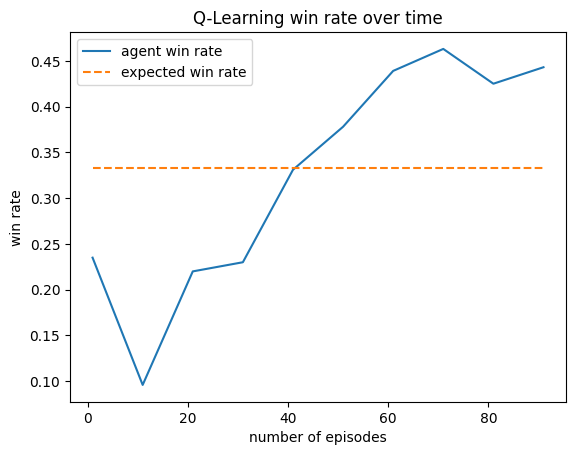

In [15]:
RLTRAINING_FUNCS = {'decision_fn': rltraining_decision, 'block_fn': income_block, 'dispose_fn': random_dispose, 'keep_fn': random_keep}
players = [Player('Player 1', RLTRAINING_FUNCS), Player('Player 2', RANDOM_FUNCS), Player('Player 3', GREEDY_FUNCS)]

env = Environment('Player 1', players)

n = len(players)
state_dim = 10 + 11 * n
action_dim = 1 + 3 * n 
learning_rate = 0.001
gamma = 0.99

agent = QLearningAgent(state_dim, action_dim, learning_rate, gamma, 'Player 1')

num_episodes = 100
batch_size = 32
epsilon_decay = 0.99

total_rewards, win_rates = train_agent(agent, env, num_episodes, batch_size, epsilon_decay, display_progress=True, save_model=True, player_types=['random', 'greedy'])

Episode Loop:   0%|          | 0/1000 [00:00<?, ?it/s]

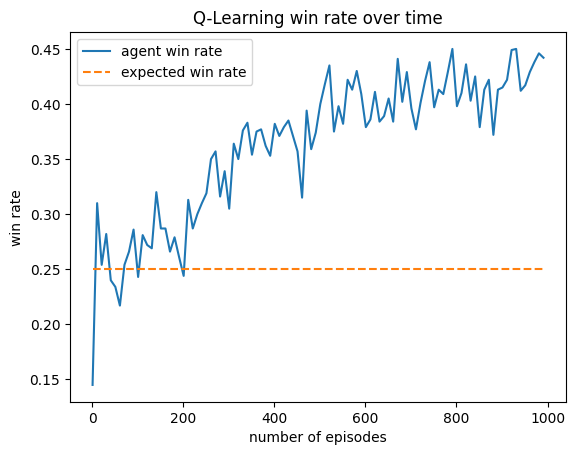

In [16]:
RLTRAINING_FUNCS = {'decision_fn': rltraining_decision, 'block_fn': income_block, 'dispose_fn': random_dispose, 'keep_fn': random_keep}
players = [Player('Player 1', RLTRAINING_FUNCS), Player('Player 2', RANDOM_FUNCS), Player('Player 3', GREEDY_FUNCS), Player('Player 4', TRUTH_FUNCS)]

env = Environment('Player 1', players)

n = len(players)
state_dim = 10 + 11 * n
action_dim = 1 + 3 * n 
learning_rate = 0.001
gamma = 0.99

agent = QLearningAgent(state_dim, action_dim, learning_rate, gamma, 'Player 1')

num_episodes = 1000
batch_size = 32
epsilon_decay = 0.99

total_rewards, win_rates = train_agent(agent, env, num_episodes, batch_size, epsilon_decay, display_progress=True, save_model=True, player_types=['random', 'greedy', 'truth'])

Episode Loop:   0%|          | 0/5000 [00:00<?, ?it/s]

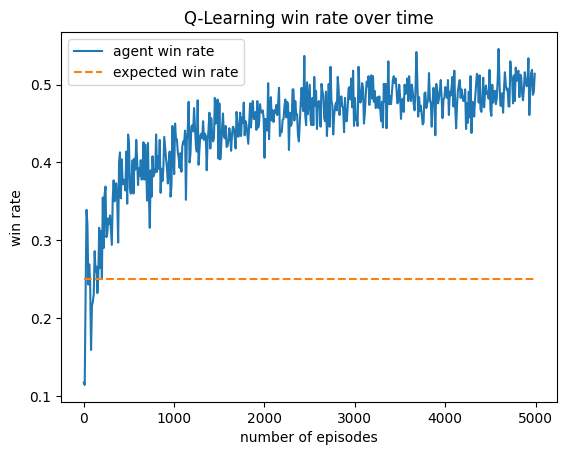

In [17]:
RLTRAINING_FUNCS = {'decision_fn': rltraining_decision, 'block_fn': income_block, 'dispose_fn': random_dispose, 'keep_fn': random_keep}
players = [Player('Player 1', RLTRAINING_FUNCS), Player('Player 2', RANDOM_FUNCS), Player('Player 3', GREEDY_FUNCS), Player('Player 4', TRUTH_FUNCS)]

env = Environment('Player 1', players)

n = len(players)
state_dim = 10 + 11 * n
action_dim = 1 + 3 * n 
learning_rate = 0.001
gamma = 0.99

agent = QLearningAgent(state_dim, action_dim, learning_rate, gamma, 'Player 1')

num_episodes = 5000
batch_size = 32
epsilon_decay = 0.99

total_rewards, win_rates = train_agent(agent, env, num_episodes, batch_size, epsilon_decay, display_progress=True, save_model=True, player_types=['random', 'greedy', 'truth'])

Episode Loop:   0%|          | 0/5000 [00:00<?, ?it/s]

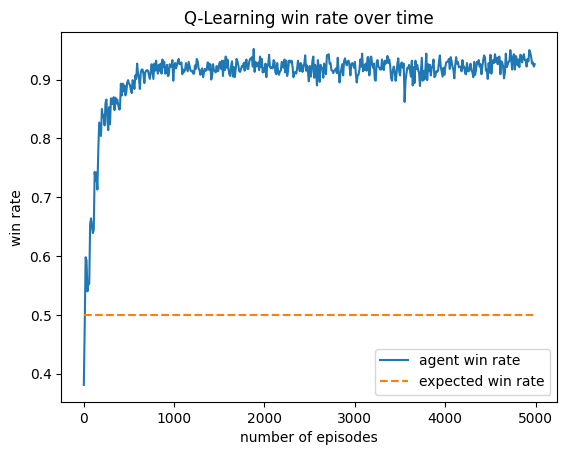

In [18]:
RLTRAINING_FUNCS = {'decision_fn': rltraining_decision, 'block_fn': income_block, 'dispose_fn': random_dispose, 'keep_fn': random_keep}
players = [Player('Player 1', RLTRAINING_FUNCS), Player('Player 2', RANDOM_FUNCS)]

env = Environment('Player 1', players)

n = len(players)
state_dim = 10 + 11 * n
action_dim = 1 + 3 * n 
learning_rate = 0.001
gamma = 0.99

agent = QLearningAgent(state_dim, action_dim, learning_rate, gamma, 'Player 1')

num_episodes = 5000
batch_size = 32
epsilon_decay = 0.99

total_rewards, win_rates = train_agent(agent, env, num_episodes, batch_size, epsilon_decay, display_progress=True, save_model=True, player_types=['random'])

Episode Loop:   0%|          | 0/5000 [00:00<?, ?it/s]

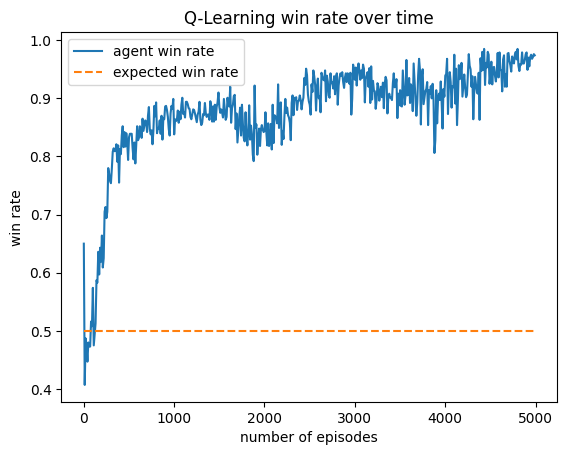

In [19]:
RLTRAINING_FUNCS = {'decision_fn': rltraining_decision, 'block_fn': income_block, 'dispose_fn': random_dispose, 'keep_fn': random_keep}
players = [Player('Player 1', RLTRAINING_FUNCS), Player('Player 2', INCOME_FUNCS)]

env = Environment('Player 1', players)

n = len(players)
state_dim = 10 + 11 * n
action_dim = 1 + 3 * n 
learning_rate = 0.001
gamma = 0.99

agent = QLearningAgent(state_dim, action_dim, learning_rate, gamma, 'Player 1')

num_episodes = 5000
batch_size = 32
epsilon_decay = 0.99

total_rewards, win_rates = train_agent(agent, env, num_episodes, batch_size, epsilon_decay, display_progress=True, save_model=True, player_types=['income'])

Episode Loop:   0%|          | 0/1500 [00:00<?, ?it/s]

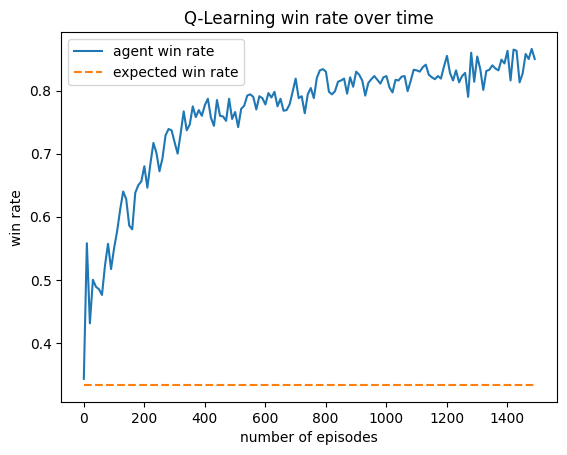

In [20]:
RLTRAINING_FUNCS = {'decision_fn': rltraining_decision, 'block_fn': income_block, 'dispose_fn': random_dispose, 'keep_fn': random_keep}
players = [Player('Player 1', RLTRAINING_FUNCS), Player('Player 2', RANDOM_FUNCS), Player('Player 3', RANDOM_FUNCS)]

env = Environment('Player 1', players)

n = len(players)
state_dim = 10 + 11 * n
action_dim = 1 + 3 * n 
learning_rate = 0.001
gamma = 0.99

agent = QLearningAgent(state_dim, action_dim, learning_rate, gamma, 'Player 1')

num_episodes = 1500
batch_size = 32
epsilon_decay = 0.99

total_rewards, win_rates = train_agent(agent, env, num_episodes, batch_size, epsilon_decay, display_progress=True, save_model=True, player_types=['random', 'random'])

Episode Loop:   0%|          | 0/1500 [00:00<?, ?it/s]

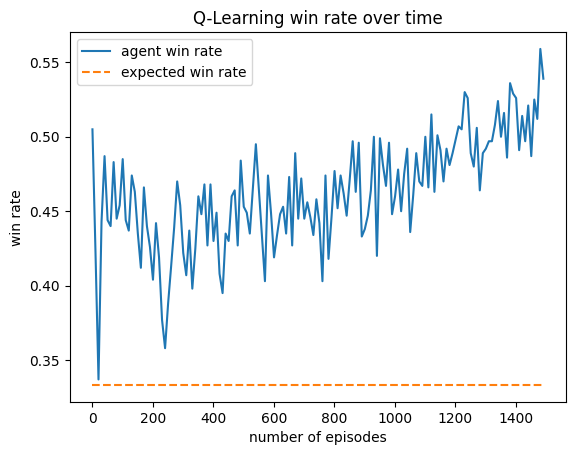

In [21]:
RLTRAINING_FUNCS = {'decision_fn': rltraining_decision, 'block_fn': income_block, 'dispose_fn': random_dispose, 'keep_fn': random_keep}
players = [Player('Player 1', RLTRAINING_FUNCS), Player('Player 2', INCOME_FUNCS), Player('Player 3', INCOME_FUNCS)]

env = Environment('Player 1', players)

n = len(players)
state_dim = 10 + 11 * n
action_dim = 1 + 3 * n 
learning_rate = 0.001
gamma = 0.99

agent = QLearningAgent(state_dim, action_dim, learning_rate, gamma, 'Player 1')

num_episodes = 1500
batch_size = 32
epsilon_decay = 0.99

total_rewards, win_rates = train_agent(agent, env, num_episodes, batch_size, epsilon_decay, display_progress=True, save_model=True, player_types=['income', 'income'])